In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Параметры области
x0, x1 = 0, np.pi
y0, y1 = -1, 1

# Правая часть уравнения и точное решение
def f_source(x, y):
    return 4 - 29 * np.sin(2 * x + 5 * y)

def exact_solution(x, y):
    return np.sin(2 * x + 5 * y) + 2 * y**2


**1. Начальное уравнение**

Мы решаем уравнение Пуассона:

$$
u_{xx} + u_{yy} = f(x,y)
$$

в прямоугольной области.

---

**2. Переход к сетке**

Разбиваем область на сетку:

$$
x_i = x_0 + i h_x,\qquad y_j = y_0 + j h_y.
$$

Значение функции:

$$
u_{i,j} \approx u(x_i, y_j)
$$

---
**3. Разностная аппроксимация производных**

### Вторая производная по x:

$$
u_{xx}(x_i,y_j) \approx
\frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{h_x^2}
$$

### Вторая производная по y:

$$
u_{yy}(x_i,y_j) \approx
\frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{h_y^2}
$$

Подставляем в уравнение Пуассона:

$$
\frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{h_x^2}
+
\frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{h_y^2}
=
f_{i,j}.
$$

---

**4. Вид (Au = b)**

Пусть оператор Лапласа на сетке — это матрица (A). Тогда:

$$
(Au)_{i,j} = b_{i,j} = f_{i,j}.
$$

---

**5. Метод простой итерации**

Метод простой итерации для решения (Au=b):

$$
u^{(k+1)} = u^{(k)} + \tau (b - A u^{(k)}).
$$

Подставляем разностный Лаплас:

$$
(Au)^{k}_{i,j} =
\frac{u^k_{i-1,j} - 2u^k_{i,j} + u^k_{i+1,j}}{h_x^2}
+
\frac{u^k_{i,j-1} - 2u^k_{i,j} + u^k_{i,j+1}}{h_y^2}
$$

Тогда:

$$
\boxed{
u^{k+1}_{i,j}
=
u^{k}_{i,j}
+
\tau \left(
f_{i,j}
-
\frac{u^k_{i-1,j} - 2u^k_{i,j} + u^k_{i+1,j}}{h_x^2}
-
\frac{u^k_{i,j-1} - 2u^k_{i,j} + u^k_{i,j+1}}{h_y^2}
\right)
}
$$

Это **простая итерация**.

---

**6. Как из простой итерации получить метод Якоби**

Выбираем специальное значение параметра:

$$
\tau = \frac{1}{A_{ii}},
$$

где для оператора Лапласа:

$$
A_{ii} = \frac{2}{h_x^2} + \frac{2}{h_y^2}.
$$

Подставляем τ:

$$
u^{k+1}_{i,j} =
\frac{
(u^k_{i-1,j} + u^k_{i+1,j})/h_x^2
+
(u^k_{i,j-1} + u^k_{i,j+1})/h_y^2
-
f_{i,j}
}{
\frac{2}{h_x^2} + \frac{2}{h_y^2}
}.
$$

Это и есть **метод Якоби**.



In [2]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_poisson(nx, ny):
    x = np.linspace(0, np.pi, nx)
    y = np.linspace(-1, 1, ny)
    hx = x[1] - x[0]
    hy = y[1] - y[0]

    N = nx * ny

    A = lil_matrix((N, N))
    b = np.zeros(N)

    def idx(i, j): 
        return i * ny + j

    for i in range(nx):
        for j in range(ny):
            k = idx(i, j)

            # --- ДИРИХЛЕ ПО Y ---
            if j == 0:
                A[k, k] = 1
                b[k] = 2 + np.sin(2 * x[i] - 5)
                continue

            if j == ny - 1:
                A[k, k] = 1
                b[k] = 2 + np.sin(2 * x[i] + 5)
                continue

            # --- ПЕРИОДИЧНОСТЬ ПО X ---
            if i == 0:
                # u(0,j) - u(nx-1, j) = 0
                k_right = idx(nx - 1, j)
                A[k, k] =  1
                A[k, k_right] = -1
                b[k] = 0
                continue

            if i == nx - 1:
                # u(nx-1,j) - u(0, j) = 0
                k_left = idx(0, j)
                A[k, k] =  1
                A[k, k_left] = -1
                b[k] = 0
                continue

            # --- ВНУТРЕННИЕ УЗЛЫ ---
            A[k, k] = -2.0 / hx**2 - 2.0 / hy**2

            # соседи по x
            A[k, idx(i - 1, j)] += 1.0 / hx**2
            A[k, idx(i + 1, j)] += 1.0 / hx**2

            # соседи по y
            A[k, idx(i, j - 1)] += 1.0 / hy**2
            A[k, idx(i, j + 1)] += 1.0 / hy**2

            # правая часть
            b[k] = f_source(x[i], y[j])

    # --- РЕШЕНИЕ ---
    u_vec = spsolve(A.tocsr(), b)
    u = u_vec.reshape((nx, ny))

    return x, y, u


In [3]:
"""
def solve_poisson_simple_iteration(nx, ny, tau=0.01, max_iter=50000, tol=1e-8):

    x = np.linspace(0, np.pi, nx)
    y = np.linspace(-1, 1, ny)

    hx = x[1] - x[0]
    hy = y[1] - y[0]

    hx2 = hx*hx
    hy2 = hy*hy

    X, Y = np.meshgrid(x, y, indexing='ij')

    # Инициализация
    u = np.zeros((nx, ny))

    # Дирихле по y
    u[:, 0]  = 2 + np.sin(2*x - 5)
    u[:, -1] = 2 + np.sin(2*x + 5)

    for it in range(max_iter):
        u_old = u.copy()

        # внутренние точки
        for i in range(nx):
            il = (i - 1) % nx
            ir = (i + 1) % nx

            for j in range(1, ny-1):

                laplace = (
                    (u_old[il, j] - 2*u_old[i, j] + u_old[ir, j]) / hx2 +
                    (u_old[i, j-1] - 2*u_old[i, j] + u_old[i, j+1]) / hy2
                )

                u[i, j] = u_old[i, j] + tau * (f_source(x[i], y[j]) - laplace)

        # Периодичность
        u[0, :]  = u[-2, :]
        u[-1, :] = u[1, :]

        diff = np.max(np.abs(u - u_old))
        if diff < tol:
            print(f"Converged after {it+1} iterations, diff={diff:.3e}")
            break
    else:
        print("NOT CONVERGED")

    return X, Y, u

"""

'\ndef solve_poisson_simple_iteration(nx, ny, tau=0.01, max_iter=50000, tol=1e-8):\n\n    x = np.linspace(0, np.pi, nx)\n    y = np.linspace(-1, 1, ny)\n\n    hx = x[1] - x[0]\n    hy = y[1] - y[0]\n\n    hx2 = hx*hx\n    hy2 = hy*hy\n\n    X, Y = np.meshgrid(x, y, indexing=\'ij\')\n\n    # Инициализация\n    u = np.zeros((nx, ny))\n\n    # Дирихле по y\n    u[:, 0]  = 2 + np.sin(2*x - 5)\n    u[:, -1] = 2 + np.sin(2*x + 5)\n\n    for it in range(max_iter):\n        u_old = u.copy()\n\n        # внутренние точки\n        for i in range(nx):\n            il = (i - 1) % nx\n            ir = (i + 1) % nx\n\n            for j in range(1, ny-1):\n\n                laplace = (\n                    (u_old[il, j] - 2*u_old[i, j] + u_old[ir, j]) / hx2 +\n                    (u_old[i, j-1] - 2*u_old[i, j] + u_old[i, j+1]) / hy2\n                )\n\n                u[i, j] = u_old[i, j] + tau * (f_source(x[i], y[j]) - laplace)\n\n        # Периодичность\n        u[0, :]  = u[-2, :]\n        u[-1

In [ ]:
def calculate_error(X, Y, u_numeric):
    u_exact = exact_solution(X, Y)
    error = np.abs(u_numeric - u_exact)
    return u_exact, error

def plot_results(X, Y, u_numeric, u_exact, error):
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, u_numeric, cmap='viridis')
    ax1.set_title("Численное решение")
    ax1.set_xlabel("x"); ax1.set_ylabel("y")
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, u_exact, cmap='viridis')
    ax2.set_title("Точное решение")
    ax2.set_xlabel("x"); ax2.set_ylabel("y")
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, error, cmap='hot')
    ax3.set_title("Погрешность")
    ax3.set_xlabel("x"); ax3.set_ylabel("y")
    
    plt.tight_layout()
    plt.show()

def calculate_err(X, Y, u_numeric):
    u_exact = exact_solution(X, Y)

    # покомпонентная ошибка
    diff = u_numeric - u_exact

    # среднеквадратичная ошибка (RMSE)
    rmse = np.sqrt(np.mean(diff**2))

    return rmse


def check_convergence_order():
    n_list = [5, 10, 20]
    errors = []
    
    for n in n_list:
        print(f"\nРешаем при n = {n}")
        x, y, u_num = solve_poisson(n, n)
        X, Y = np.meshgrid(x, y, indexing='ij')
        u_exact, err = calculate_error(X, Y, u_num)
        max_err = np.max(err)

        errors.append(max_err)
        print(f"Максимальная ошибка: {max_err:.2e}")
    
    print("\nАнализ порядка аппроксимации:")
    for i in range(1, len(errors)):
        p = np.log(errors[i-1] / errors[i]) / np.log(n_list[i] / n_list[i-1])
        print(f"Порядок между n={n_list[i-1]} и n={n_list[i]}: p ≈ {p:.3f}")


Решение уравнения Пуассона методом простой итерации...


C:\Users\1TB\AppData\Local\Temp\ipykernel_12540\727159609.py:65: MatrixRankWarning: Matrix is exactly singular
  u_vec = spsolve(A.tocsr(), b)


ValueError: Argument Z must be 2-dimensional.

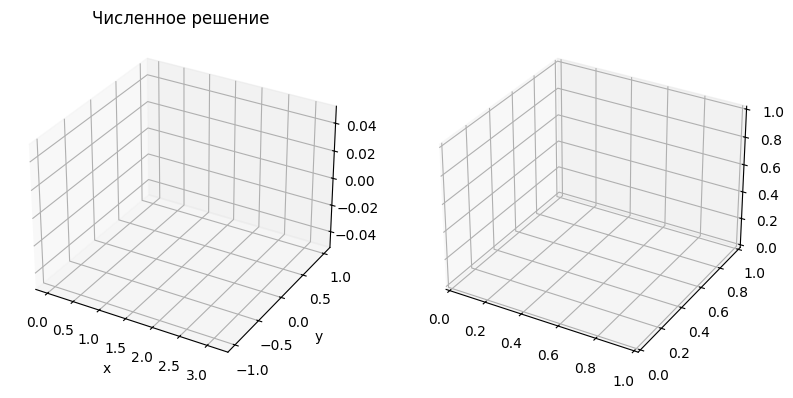

In [ ]:
def main():
    print("Решение уравнения Пуассона методом простой итерации...")
    x, y, u_num = solve_poisson(40, 40)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_exact, error = calculate_error(X, Y, u_num)
    
    plot_results(X, Y, u_num, u_exact, error)
    check_convergence_order()

if __name__ == "__main__":
    main()
